# ADCP Data Processing for FOCUS Cruise October 2024

In [14]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import glob
import cmocean.cm as cmo
import cartopy.crs as ccrs
import matplotlib as mpl
import cartopy.feature as cfeature
import geopandas as gpd
import warnings
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
warnings.filterwarnings("ignore")

font = {'family' : 'Avenir',
        'weight' : 'normal',
        'size'   : 20}
mpl.rc('font', **font)

In [15]:
def rot_ticks(axs,rot,ha):
    for xlabels in axs.get_xticklabels():
                xlabels.set_rotation(rot)
                xlabels.set_ha(ha)

In [16]:
def add_features(ax):
    
    ax.add_feature(cfeature.LAND,   facecolor='0.8',edgecolor='k',zorder=3)
    ax.add_feature(cfeature.RIVERS, edgecolor='w'  ,zorder=3)
    ax.add_feature(cfeature.LAKES,  facecolor='w'  ,zorder=3)
    ax.set(xlabel='',ylabel='')
    
    gls = ax.gridlines(crs=ccrs.PlateCarree(), 
                        draw_labels=True,
                        x_inline=False, 
                        y_inline=False,
                        linewidth=0.75,
                        alpha=0.75, 
                        linestyle='--',
                        lw=0,
                        color='k',
                        ylocs=mpl.ticker.MultipleLocator(base=2),
                        xlocs=mpl.ticker.MultipleLocator(base=2))

    gls.top_labels = False
    gls.bottom_labels = True
    gls.right_labels = False    
    gls.left_labels = True
    gls.xpadding=10
    gls.ypadding=10
    for k, spine in ax.spines.items():  #ax.spines is a dictionary
        spine.set_zorder(10)

In [17]:
bathy = xr.open_dataset('gebco_fs_2023.nc')
bathy = bathy.interp(lon=np.arange(-80.5,-78.5,.05),lat=np.arange(25,27.5,.05))

In [18]:
ds = xr.open_dataset("os75nb.nc")

In [19]:
#can only run this once
ds['depth'] = ds['depth'].isel(time=0)
ds = ds.swap_dims({"depth_cell":"depth"})

Text(0.5, 0.98, 'FOCUS Ship ADCP Data')

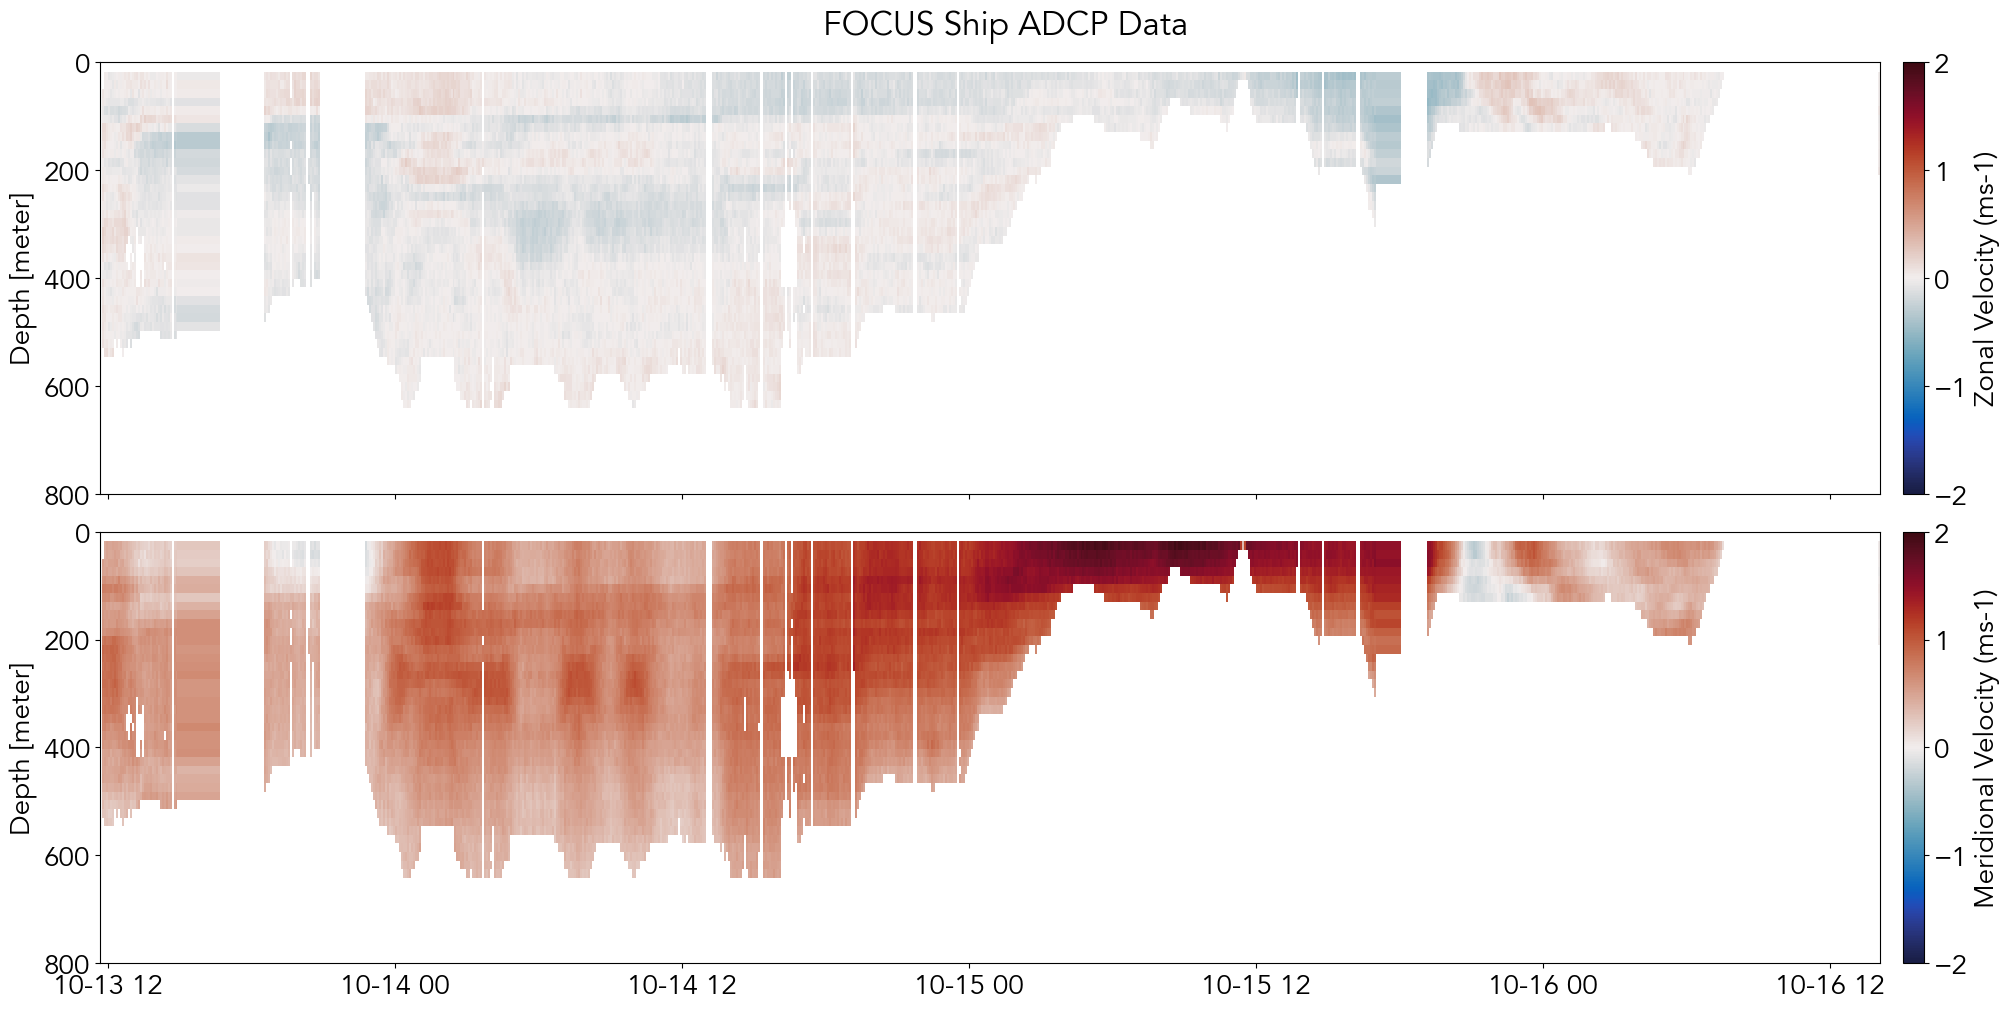

In [20]:
fig, (ax, bx) = plt.subplots(2, 1, figsize=(20,10), sharex= True, constrained_layout = True)

var = ['u', 'v']
labels = ["Zonal Velocity (ms-1)", "Meridional Velocity (ms-1)"]

for i, vari in enumerate(var):
    ds[vari].plot(y="depth", ylim=(800,0), vmin=-2, vmax=2, 
                  ax=[ax, bx][i],
                  cmap="cmo.balance",
                  cbar_kwargs={'pad':0.01,'label':labels[i]})
    
#ds["amp"].plot(y="depth", ylim=(1000,0), cmap="cmo.dense", ax=cx)

bx.xaxis.set_major_locator(mdates.HourLocator(np.arange(0,24,12)))
bx.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %H"))
rot_ticks(bx, 0, 'center')

ax.set(xlabel=None)
bx.set(xlabel=None)
#cx.set(xlabel=None)

fig.suptitle("FOCUS Ship ADCP Data")

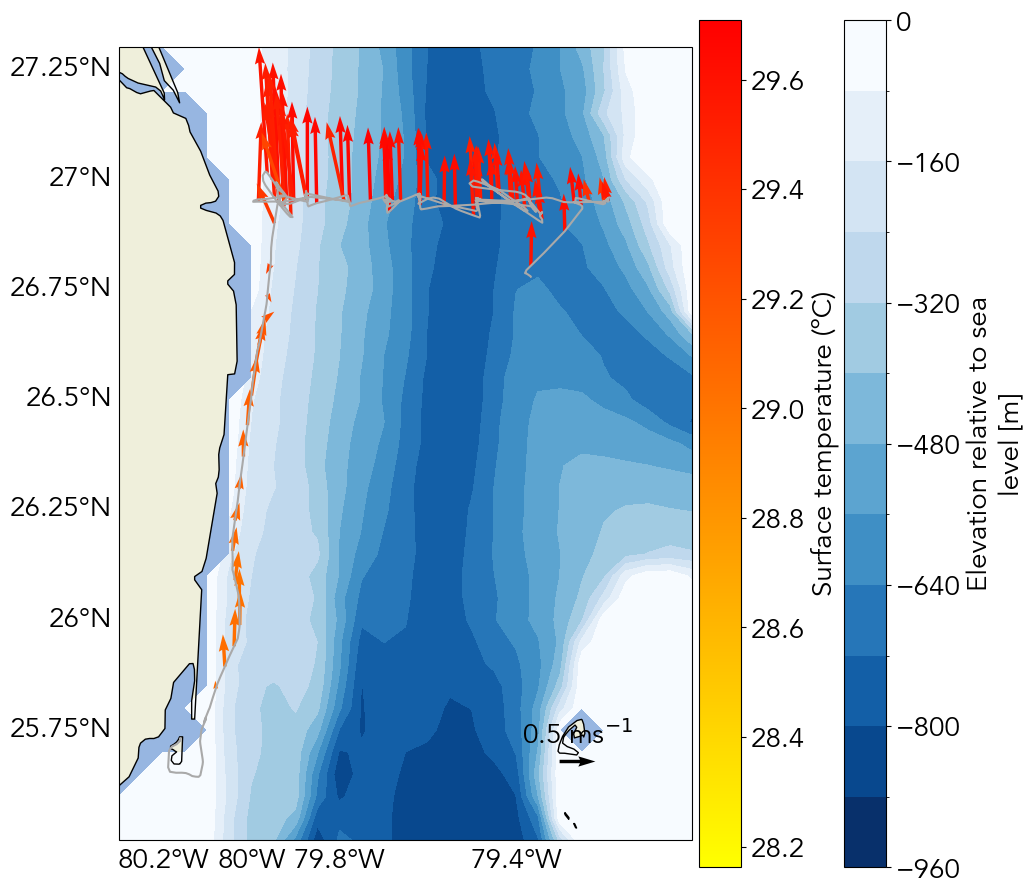

In [23]:
fig, ax = plt.subplots(figsize=(11,11), subplot_kw={"projection":ccrs.PlateCarree()})

bathy = xr.open_dataset('gebco_bathy.nc')
bathy = bathy.interp(lon=np.arange(-80.5,-78.5,.05),lat=np.arange(25,27.5,.05))    

roi_lon = slice(-82, -78)
roi_lat = slice(24, 28)

# Extract bathymetry data for the ROI
land_mask = bathy['elevation'] > 0
bathymetry_roi = bathy['elevation'].sel(lon=roi_lon, lat=roi_lat).where(~land_mask)                                                        

bathymetry_roi.plot.contourf(ax=ax, levels=15, cmap='Blues_r')
ax.plot(ds.lon, ds.lat, c="darkgrey")
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.OCEAN)
gl = ax.gridlines(lw =0, 
                  draw_labels=True)
gl.top_labels = False
gl.right_labels = False
quivplt = ds.isel(time=np.arange(0,len(ds.time),8),
                  depth=slice(0,100)).mean('depth').plot.quiver(x='lon',
                                                                y='lat',
                                                                u='u',
                                                                v='v',
                                                                scale=8,
                                                                pivot='tail',
                                                                hue="tr_temp",
                                                                cmap="autumn_r",
                                                                cbar_kwargs={'pad':0.01,'label':'Surface temperature (ºC)'})

qk = ax.quiverkey(quivplt, 0.8, 0.1, 0.5, '0.5 ms$^{-1}$', 
                  labelpos='N',
                  coordinates='axes', zorder=6, color='k')
ax.set_extent([-80.3,-79,27.3,25.5])
#plt.title("Cruise Track with ADCP Data")